# 한-영 번역기 만들기 (v4.0.1: SentencePiece 적용)
---
## Step 1. 데이터 준비 및 SentencePiece 토크나이저 학습

In [1]:
!pip install sentencepiece

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import os
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
import time
from tqdm import tqdm
import sentencepiece as spm

import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


### 데이터 불러오기 및 전처리

In [3]:
data_dir = 'data'
train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

with open(train_kor_path, "r") as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r") as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r") as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r") as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r") as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r") as f: test_eng_raw = f.read().splitlines()

### SentencePiece 모델 학습
한국어와 영어 훈련 데이터를 합쳐 하나의 코퍼스 파일로 만들고, 이를 이용해 SentencePiece BPE 모델을 학습시킵니다.

In [4]:
corpus_path = os.path.join(data_dir, "kor-eng-corpus.txt")
if not os.path.exists(corpus_path):
    with open(corpus_path, "w", encoding="utf-8") as f:
        for sent in train_kor_raw:
            f.write(f"{sent}\n")
        for sent in train_eng_raw:
            f.write(f"{sent}\n")

spm_model_prefix = 'sentpiece_kor_eng'
vocab_size = 10000

spm_params = f'--input={corpus_path} --model_prefix={spm_model_prefix} --vocab_size={vocab_size} --model_type=bpe --max_sentence_length=9999 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3'

spm.SentencePieceTrainer.train(spm_params)

sp = spm.SentencePieceProcessor()
sp.load(f'{spm_model_prefix}.model')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/kor-eng-corpus.txt --model_prefix=sentpiece_kor_eng --vocab_size=10000 --model_type=bpe --max_sentence_length=9999 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/kor-eng-corpus.txt
  input_format: 
  model_prefix: sentpiece_kor_eng
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 9999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

True

0 all=110139 active=6212 piece=▁meet
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1891 size=840 all=110801 active=6874 piece=▁ra
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1849 size=860 all=111339 active=7412 piece=ased
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1821 size=880 all=112123 active=8196 piece=▁체
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1777 size=900 all=112904 active=8977 piece=med
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=1775 min_freq=222
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1739 size=920 all=113574 active=6281 piece=uss
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1701 size=940 all=115034 active=7741 piece=▁대통령은
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1662 size=960 all=115914 active=8621 piece=▁부시
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1623 size=980 all=116362 active=9069 piece=▁시작
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=1591 size=1000 all=117351 active=10058 piece=▁사건
bpe_model_traine

### 데이터셋 토큰화 및 텐서 변환

In [5]:
def clean_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[""]+', "", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence.strip()

def tokenize_and_convert(raw_data_kor, raw_data_eng, sp_processor, max_len=40):
    sequences_kor, sequences_eng = [], []
    for kor, eng in zip(raw_data_kor, raw_data_eng):
        kor_cleaned, eng_cleaned = clean_sentence(kor), clean_sentence(eng)
        
        kor_ids = [sp_processor.bos_id()] + sp_processor.encode_as_ids(kor_cleaned) + [sp_processor.eos_id()]
        eng_ids = [sp_processor.bos_id()] + sp_processor.encode_as_ids(eng_cleaned) + [sp_processor.eos_id()]
        
        if len(kor_ids) <= max_len and len(eng_ids) <= max_len:
            sequences_kor.append(kor_ids)
            sequences_eng.append(eng_ids)
            
    return sequences_kor, sequences_eng

train_kor_sequences, train_eng_sequences = tokenize_and_convert(train_kor_raw, train_eng_raw, sp)
dev_kor_sequences, dev_eng_sequences = tokenize_and_convert(dev_kor_raw, dev_eng_raw, sp)
test_kor_sequences, test_eng_sequences = tokenize_and_convert(test_kor_raw, test_eng_raw, sp)

010 active=10823 piece=ams
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=265 size=4780 all=200381 active=11194 piece=▁illegal
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=263 size=4800 all=200592 active=11405 piece=▁텍사
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=263 min_freq=68
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=262 size=4820 all=200755 active=10185 piece=▁pict
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=261 size=4840 all=200942 active=10372 piece=▁similar
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=259 size=4860 all=201396 active=10826 piece=▁cle
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=257 size=4880 all=201640 active=11070 piece=단을
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=256 size=4900 all=201931 active=11361 piece=▁Brazil
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=256 min_freq=67
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=255 size=4920 all=202170 active=10334 piece=���Earth
bpe_model_tr

## Step 2. 모델 설계 및 데이터셋 준비

In [6]:
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sequences[idx]), torch.tensor(self.trg_sequences[idx])

def collate_fn(batch, pad_id):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_id)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_id)
    return src_padded, trg_padded

BATCH_SIZE = 64
PAD_ID = sp.pad_id()

train_dataset = TranslationDataset(train_kor_sequences, train_eng_sequences)
valid_dataset = TranslationDataset(dev_kor_sequences, dev_eng_sequences)
test_dataset = TranslationDataset(test_kor_sequences, test_eng_sequences)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda b: collate_fn(b, PAD_ID))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, PAD_ID))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, PAD_ID))

### Attention 기반 Seq2Seq 모델 설계

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = hidden.view(self.n_layers, 2, -1, self.hidden_dim)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        hidden = torch.tanh(self.fc(hidden))
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        query = query.unsqueeze(1)
        score = self.V(torch.tanh(self.W1(query) + self.W2(values)))
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights.squeeze(-1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention, pad_idx):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        context_vector, attention_weights = self.attention(hidden[-1], encoder_outputs)
        context_vector = context_vector.unsqueeze(1)
        rnn_input = torch.cat((embedded, context_vector), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        src_len = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src_len).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t, :] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs, attentions

## Step 3. 모델 학습 및 검증

In [8]:
# 하이퍼파라미터 설정
INPUT_DIM = sp.get_piece_size()
OUTPUT_DIM = sp.get_piece_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.6
DEC_DROPOUT = 0.6
PAD_ID = sp.pad_id()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = BahdanauAttention(HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, PAD_ID)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn, PAD_ID)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID, label_smoothing=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


### 학습 및 평가 함수 정의

In [9]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.long().to(device), trg.long().to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.long().to(device), trg.long().to(device)
            output, _ = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 학습 루프 실행

  * Best Val. Loss updated: 6.991
Epoch: 01 | Time: 2.0m 46s
	Current LR: 0.001000
	Train Loss: 6.486 | Train PPL: 656.058
	 Val. Loss: 6.991 |  Val. PPL: 1086.877
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: the , , the , , the , , , .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


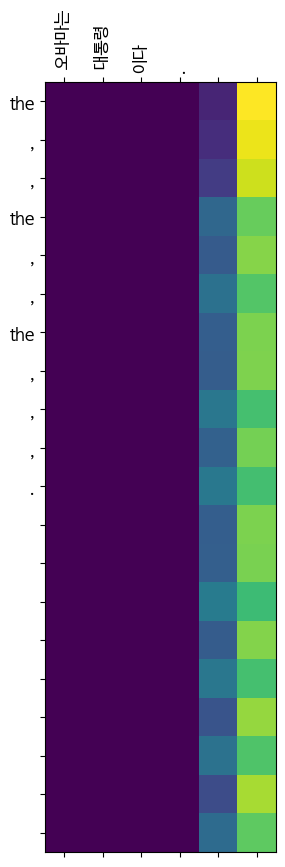

  * Best Val. Loss updated: 6.920
Epoch: 02 | Time: 2.0m 47s
	Current LR: 0.001000
	Train Loss: 6.072 | Train PPL: 433.484
	 Val. Loss: 6.920 |  Val. PPL: 1012.713
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama's america , the  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


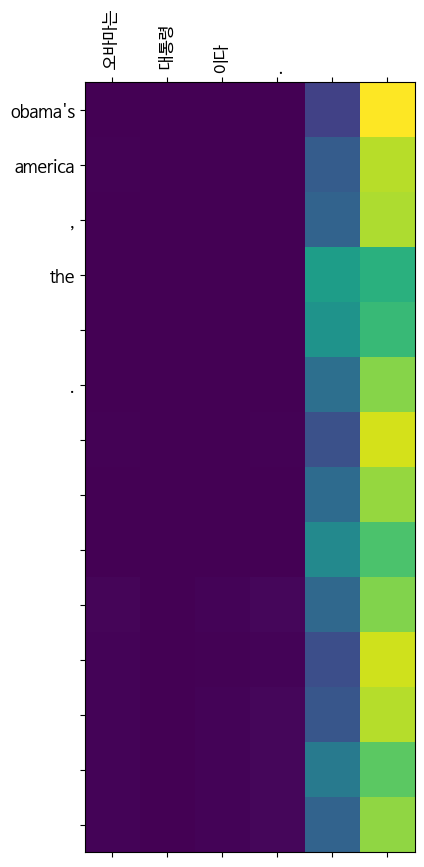

  * Best Val. Loss updated: 6.835
Epoch: 03 | Time: 2.0m 48s
	Current LR: 0.001000
	Train Loss: 5.865 | Train PPL: 352.465
	 Val. Loss: 6.835 |  Val. PPL: 929.519
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama's a obama's a , , the  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


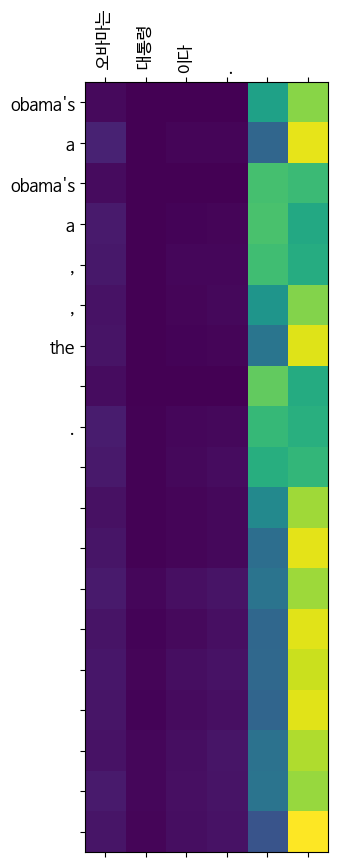

  * Early Stopping Counter: 1/3
Epoch: 04 | Time: 2.0m 47s
	Current LR: 0.001000
	Train Loss: 5.750 | Train PPL: 314.260
	 Val. Loss: 6.850 |  Val. PPL: 944.014
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama's president ,, the is a , the , , .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


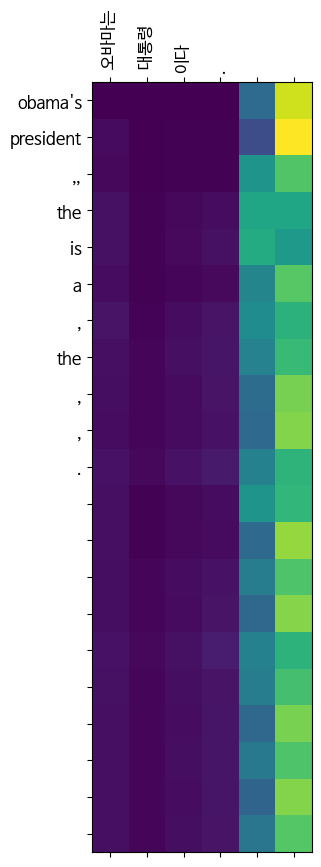

  * Early Stopping Counter: 2/3
Epoch: 05 | Time: 2.0m 48s
	Current LR: 0.000500
	Train Loss: 5.665 | Train PPL: 288.722
	 Val. Loss: 6.867 |  Val. PPL: 960.157
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a , obama is a , the , , .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


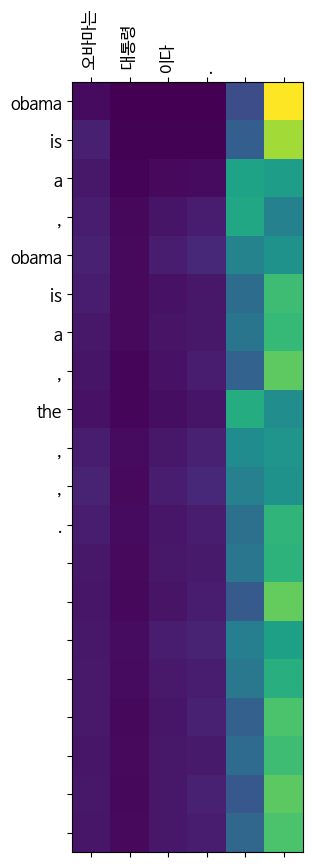

  * Best Val. Loss updated: 6.787
Epoch: 06 | Time: 2.0m 48s
	Current LR: 0.000500
	Train Loss: 5.576 | Train PPL: 264.122
	 Val. Loss: 6.787 |  Val. PPL: 886.129
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a to the the , the is a , the  , the  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


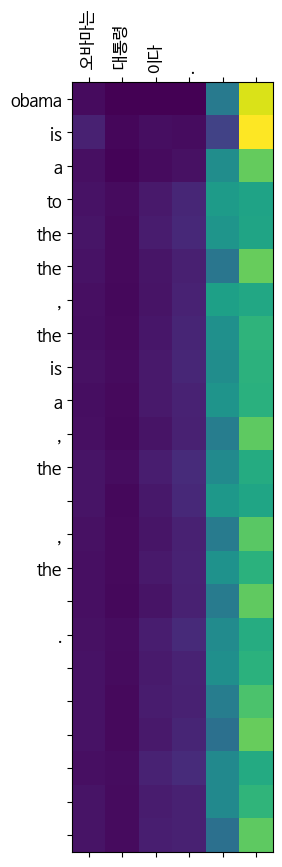

  * Early Stopping Counter: 1/3
Epoch: 07 | Time: 2.0m 48s
	Current LR: 0.000500
	Train Loss: 5.547 | Train PPL: 256.479
	 Val. Loss: 6.804 |  Val. PPL: 901.091
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a to the , the , , , , .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


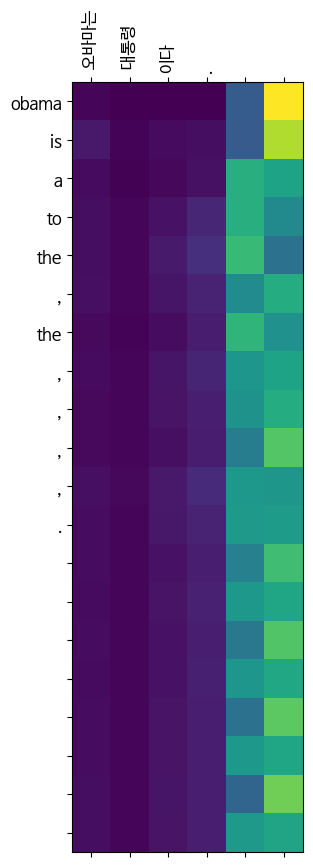

  * Best Val. Loss updated: 6.769
Epoch: 08 | Time: 2.0m 48s
	Current LR: 0.000500
	Train Loss: 5.512 | Train PPL: 247.729
	 Val. Loss: 6.769 |  Val. PPL: 870.382
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a , obama is a , obama is a  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


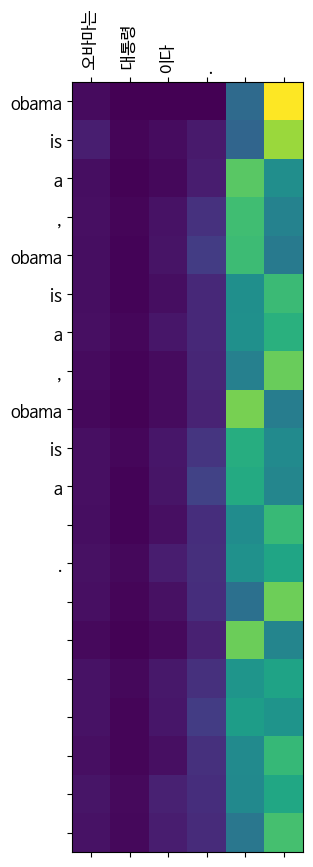

  * Early Stopping Counter: 1/3
Epoch: 09 | Time: 2.0m 47s
	Current LR: 0.000500
	Train Loss: 5.482 | Train PPL: 240.361
	 Val. Loss: 6.774 |  Val. PPL: 874.430
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a to obama is a , obama is a .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


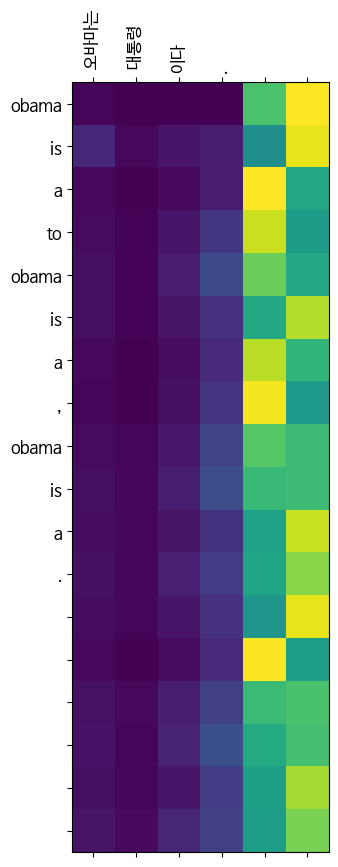

  * Early Stopping Counter: 2/3
Epoch: 10 | Time: 2.0m 48s
	Current LR: 0.000250
	Train Loss: 5.458 | Train PPL: 234.707
	 Val. Loss: 6.776 |  Val. PPL: 876.976
--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a , obama is a , obama is a .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


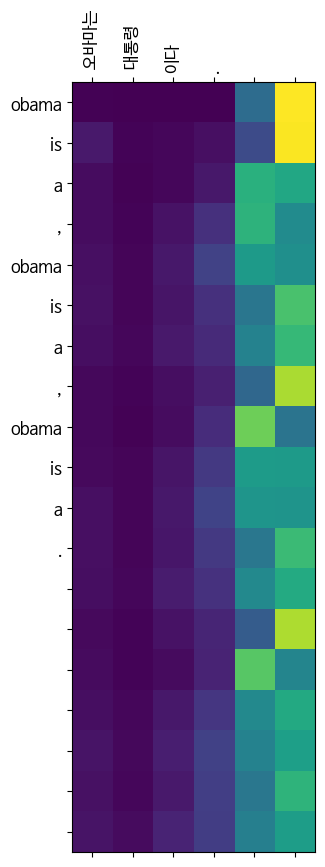

  * Early Stopping Counter: 3/3
[Early Stopping] Validation loss did not improve for 3 epochs. Stopping training...


In [10]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    attention = attention.cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='viridis')
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, rotation=90)
    ax.set_yticks(range(len(translation)))
    ax.set_yticklabels(translation)
    ax.tick_params(labelsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate_and_show_attention(sentence, model, sp_processor, device, max_len=50):
    model.eval()
    src_tokens = sp_processor.encode_as_pieces(sentence)
    src_indexes = [sp_processor.bos_id()] + sp_processor.encode_as_ids(sentence) + [sp_processor.eos_id()]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [sp_processor.bos_id()]
    attentions = torch.zeros(max_len, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention.squeeze(0)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == sp_processor.eos_id():
            break

    trg_tokens = sp_processor.decode_ids(trg_indexes[1:-1])
    print(f'Original: {sentence}')
    print(f"Translated: {trg_tokens}")
    display_attention(src_tokens, trg_tokens.split(' '), attentions[:len(trg_indexes)-1, :len(src_indexes)])

N_EPOCHS = 100
CLIP = 1
PATIENCE = 3
best_valid_loss = float('inf')
patience_counter = 0
attention_check_sentence = "오바마는 대통령이다."

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'translator-ko-en-v5-sp.pt')
        patience_counter = 0
        print(f"  * Best Val. Loss updated: {best_valid_loss:.3f}")
    else:
        patience_counter += 1
        print(f"  * Early Stopping Counter: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"[Early Stopping] Validation loss did not improve for {PATIENCE} epochs. Stopping training...")
        break

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s')
    print(f'	Current LR: {current_lr:.6f}')
    print(f'	Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'	 Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

    print("--- Checking Attention Map ---")
    translate_and_show_attention(attention_check_sentence, model, sp, device)
    model.train()

## Step 4. 최종 테스트 및 번역 시각화

In [11]:
model.load_state_dict(torch.load('translator-ko-en-v5-sp.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 6.767 | Test PPL: 868.773 |


Original: 오바마는 대통령이다.
Translated: obama is a , obama is a , obama is a  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


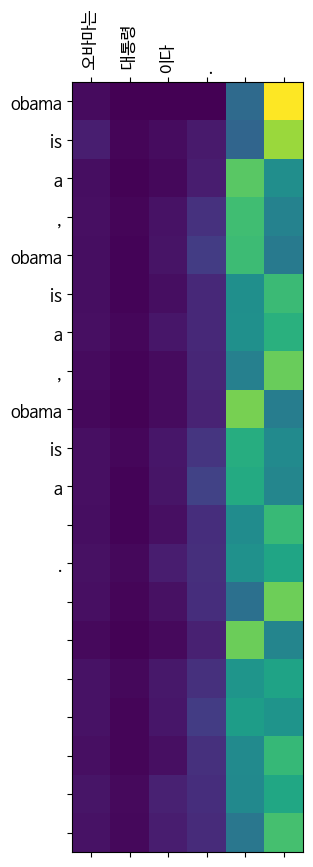


Original: 시민들은 도시 속에 산다.
Translated: the are the the the of the , , the  , the  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


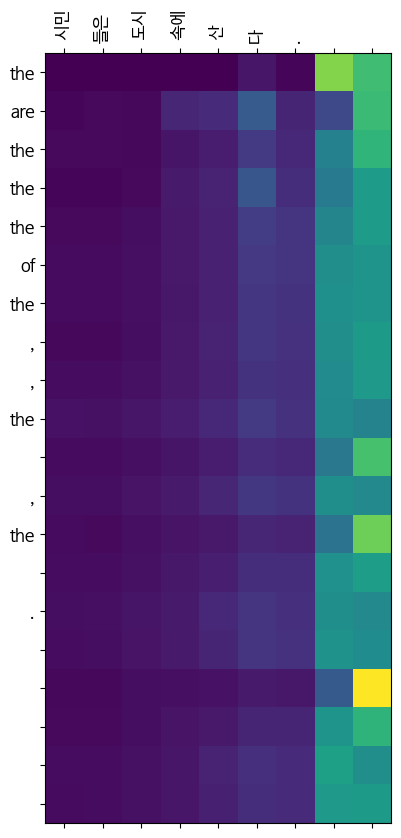


Original: 커피는 필요 없다.
Translated: it's not not to the the  , but it's not  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


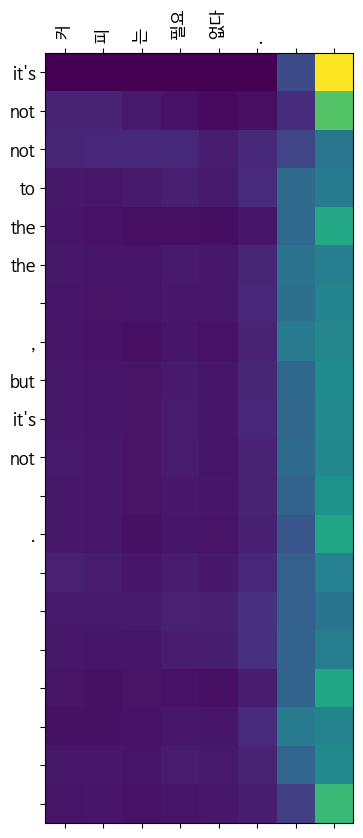


Original: 일곱 명의 사망자가 발생했다.
Translated: the people were killed in the  , , ,  .


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


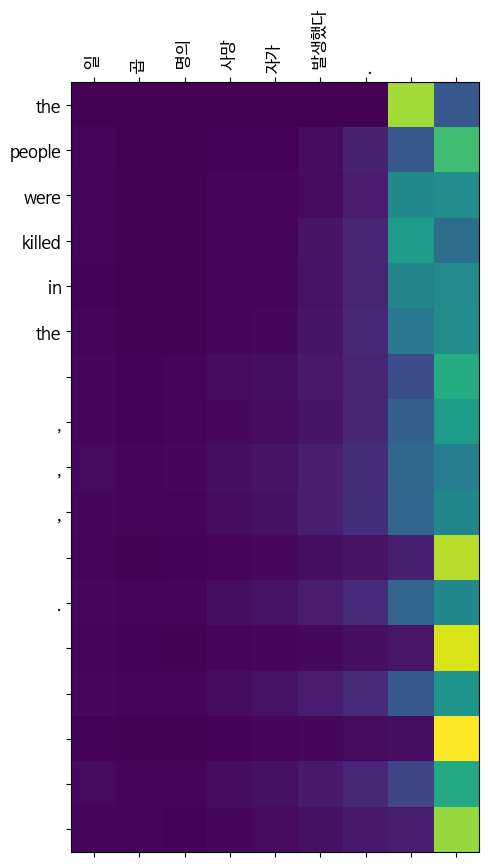

In [12]:
# 예문 번역 및 어텐션 시각화
example_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in example_sentences:
    translate_and_show_attention(sentence, model, sp, device)
    print()